In [1]:
import torch
from torch.utils.data import Dataset
import sys
sys.path.append("../../spatial-clust-scripts-main/")
import model

import warnings
import numpy as np
import leidenalg
import igraph as ig
import scanpy as sc
import anndata as ad
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import graph

import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from validclust import dunn
from sklearn.metrics import pairwise_distances
import os
plt.rcParams["figure.figsize"] = (8, 6)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## model

In [2]:
class SNAP_GNN(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.fc = nn.Linear(in_features=args.gnn_input_dim, out_features=args.fc_dim)
        self.cnn_fc = nn.Linear(in_features=args.cnn_input_dim, out_features=args.cnn_dim)
        self.feat_conv1 = GCNConv(args.fc_dim, args.latent_dim)
        self.feat_conv2 = GCNConv(args.latent_dim, args.fc_out_dim)
        
        self.spat_conv1 = GCNConv(args.cnn_dim, args.cnn_latent_dim)
        self.spat_conv2 = GCNConv(args.cnn_latent_dim, args.cnn_out_dim)
        
        self.proj1 = nn.Linear(in_features=args.fc_out_dim+args.cnn_out_dim, 
                              out_features=args.hid_out_dim)
        self.proj2 = nn.Linear(in_features=args.hid_out_dim, 
                              out_features=args.out_dim)
        #self.proj = nn.Linear(in_features=args.fc_out_dim+args.cnn_out_dim, 
                              #out_features=args.out_dim)

    def feat_gnn_encoder(self, feat, feat_edge_index):
        feat = F.relu(self.fc(feat))
        feat = F.relu(self.feat_conv1(feat, feat_edge_index))
        feat = self.feat_conv2(feat, feat_edge_index)
        
        return feat
    
    def spat_gnn_encoder(self, spat, spat_edge_index):
        spat = F.relu(self.cnn_fc(spat))
        spat = F.relu(self.spat_conv1(spat, spat_edge_index))
        spat = self.spat_conv2(spat, spat_edge_index)
        
        return spat
    
    def encoder(self, feat, spat, feat_edge_index, spat_edge_index):
        x_feat = self.feat_gnn_encoder(feat, feat_edge_index)
        x_spat = self.spat_gnn_encoder(spat, spat_edge_index)
        x = torch.cat((x_feat, x_spat), dim = 1)
        return x
    

    def forward(self, feat, spat, feat_edge_index, spat_edge_index):
        x = F.relu(self.encoder(feat, spat, feat_edge_index, spat_edge_index))
        x = self.proj1(x)
        x = F.relu(x)
        x = self.proj2(x)
        return x


## hyper

In [3]:
class Args:
    gnn_input_dim = 31
    cnn_input_dim = 128
    fc_dim = latent_dim = 32
    cnn_dim = cnn_latent_dim = 32
    out_dim = 15 * 2
    #fc_out_dim = cnn_out_dim = 16
    fc_out_dim = 33
    cnn_out_dim = 11
    hid_out_dim = 33

    criterion = "L1"
    learning_rate = 1e-3
    epochs = 10000
    print_every = 1000
    average_iter = 100
    device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

args = Args()

## load data

In [6]:
# bokai 
metaload_path = '/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/spleen/data/'
# sheng other meta
metaload_path2 = '../../../../../data/codex_murine/processed_data' # only for images etc

df_clean = pd.read_csv(os.path.join(metaload_path,  "features_and_metadata.csv"), index_col=0)
cell_nbhd = np.load(os.path.join(metaload_path,  "cell_nbhd_res0.5_k20_0325.npy"))
train_mask = np.load(os.path.join(metaload_path2, "meta_data", "train_mask.npy"))
feature_labels = np.load(os.path.join(metaload_path,  "feature_labels_res0.5_0325.npy"))
feature_edges = np.load(os.path.join(metaload_path,  "feature_edges_res0.5_0325.npy"))
spatial_edges = np.load(os.path.join(metaload_path,  "spatial_edges_0325.npy"))

In [7]:
print([cell_nbhd.shape, train_mask.shape, len(np.unique(feature_labels))])

[(53500, 15), (53500,), 15]


In [8]:
features_names = [
        'CD45',
        'Ly6C',
        'TCR',
        'Ly6G',
        'CD19',
        'CD169',
        'CD106',
        'CD3',
        'CD1632',
        'CD8a',
        'CD90',
        'F480',
        'CD11c',
        'Ter119',
        'CD11b',
        'IgD',
        'CD27',
        'CD5',
        'CD79b',
        'CD71',
        'CD31',
        'CD4',
        'IgM',
        'B220',
        'ERTR7',
        'MHCII',
        'CD35',
        'CD2135',
        'CD44',
        'nucl',
        'NKp46'
    ]
features = df_clean[features_names].to_numpy()
features = utils.center_scale(features)

In [9]:
features = torch.from_numpy(features).float().to(args.device)
feat_edge_index = torch.from_numpy(np.array(feature_edges.T[:2])).long().to(args.device)
spat_edge_index = torch.from_numpy(np.array(spatial_edges.T[:2])).long().to(args.device)

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [11]:
cnn_embedding = np.load("/mnt/cloud1/sheng-projects/st_projects/spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/spleen/data/cnn_0325/cnn_512_l1_layer6/epochs/embed/cnn_512_notrans_l1_layer6_byepoch/cnn_embedding_512_full_l1_dim128_epoch400.npy")
args.criterion = "L1"
verbose = True
model = SNAP_GNN(args)
cnn_feature = torch.from_numpy(cnn_embedding).float().to(args.device)

In [12]:
df_clean['res0.5'] = feature_labels
reslabel = pd.get_dummies(df_clean['res0.5'])
combo_nbhd = np.hstack([reslabel, cell_nbhd])
print(combo_nbhd.shape)
combo_nbhd = torch.from_numpy(combo_nbhd).float().to(args.device)

(53500, 30)


## train double shot GNN

In [13]:
def get_gnn_embed(model, cell_nbhd, feat, spat, feat_edge_index, spat_edge_index, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    cell_nbhd = cell_nbhd.to(args.device)
    model = model.to(args.device)
    if args.criterion == "L1":
        print("Use L1 Loss")
        criterion = nn.L1Loss()
    elif args.criterion == "L2":
        print("Use L2 Loss")
        criterion = nn.MSELoss()
    else:
        print("Cross Entropy")
        criterion = nn.CrossEntropyLoss()

    train_loss_epoch = []
    #criterion = nn.L1Loss()
    for e in range(1, 1+args.epochs):
        model.train()
        predicted_nbhd = model(features, cnn_feature, feat_edge_index, spat_edge_index)
        # Compute prediction error
        loss = criterion(predicted_nbhd, cell_nbhd)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # take one step
        optimizer.step()

        # record the loss
        curr_train_loss = loss.item()
        if verbose and e % args.print_every  == 0:
            print(f'===Epoch {e}, the training loss is {curr_train_loss:>0.8f}==', flush=True)
        train_loss_epoch.append(curr_train_loss)
    return model.encoder(feat, spat, feat_edge_index, spat_edge_index).cpu().detach().numpy()


Use L1 Loss
===Epoch 1000, the training loss is 0.03582001==
===Epoch 2000, the training loss is 0.03352863==
===Epoch 3000, the training loss is 0.03328346==
===Epoch 4000, the training loss is 0.03060606==
===Epoch 5000, the training loss is 0.02677447==
===Epoch 6000, the training loss is 0.02615158==
===Epoch 7000, the training loss is 0.02577714==
===Epoch 8000, the training loss is 0.02567420==
===Epoch 9000, the training loss is 0.02562559==
===Epoch 10000, the training loss is 0.02527843==
Use L1 Loss
===Epoch 1000, the training loss is 0.04179474==
===Epoch 2000, the training loss is 0.04086749==
===Epoch 3000, the training loss is 0.04012833==
===Epoch 4000, the training loss is 0.03926851==
===Epoch 5000, the training loss is 0.03749958==
===Epoch 6000, the training loss is 0.03736555==
===Epoch 7000, the training loss is 0.03720878==
===Epoch 8000, the training loss is 0.03634039==
===Epoch 9000, the training loss is 0.03605798==
===Epoch 10000, the training loss is 0.03608

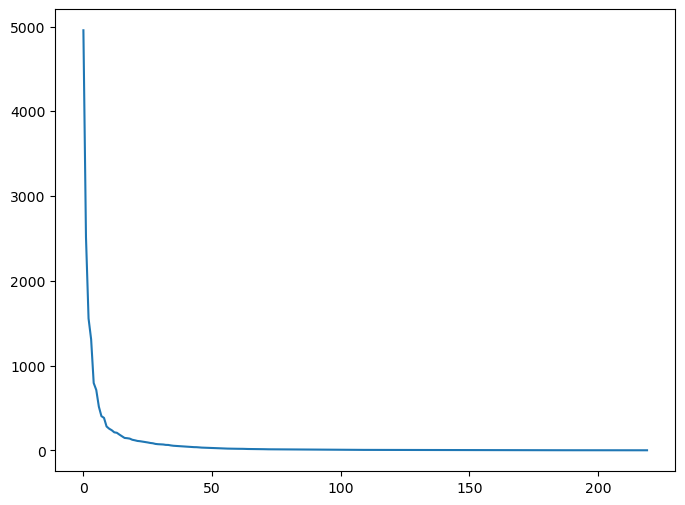

In [14]:
stable = True
if stable:
    rep = 5
    dim = args.fc_out_dim + args.cnn_out_dim
    concat_embedding = np.zeros((features.shape[0], rep * dim))
    for i in range(rep):
        gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn_feature, feat_edge_index, spat_edge_index, verbose=True)
        concat_embedding[:, i*dim : (i+1)*dim] = gnn_embedding
    Ue, Se, Vhe = np.linalg.svd(concat_embedding, full_matrices=False)
    plt.plot(Se)
    k = 32
    gnn_embedding = Ue[:, :k] @ np.diag(Se[:k])
else:
    gnn_embedding = get_gnn_embed(SNAP_GNN(args), combo_nbhd, features, cnn_feature, feat_edge_index, spat_edge_index, verbose=True)


## evaluate

In [16]:
gnn_adata = ad.AnnData(gnn_embedding)
sc.pp.scale(gnn_adata)
gnn_adata.obs['annotation'] = list(df_clean['cluster.termV2'])
sc.tl.pca(gnn_adata, svd_solver='arpack')
# sc.pp.neighbors(feature_adata, n_neighbors=10, n_pcs=40)

/tmp/ipykernel_1612627/648106255.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  gnn_adata = ad.AnnData(gnn_embedding)


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

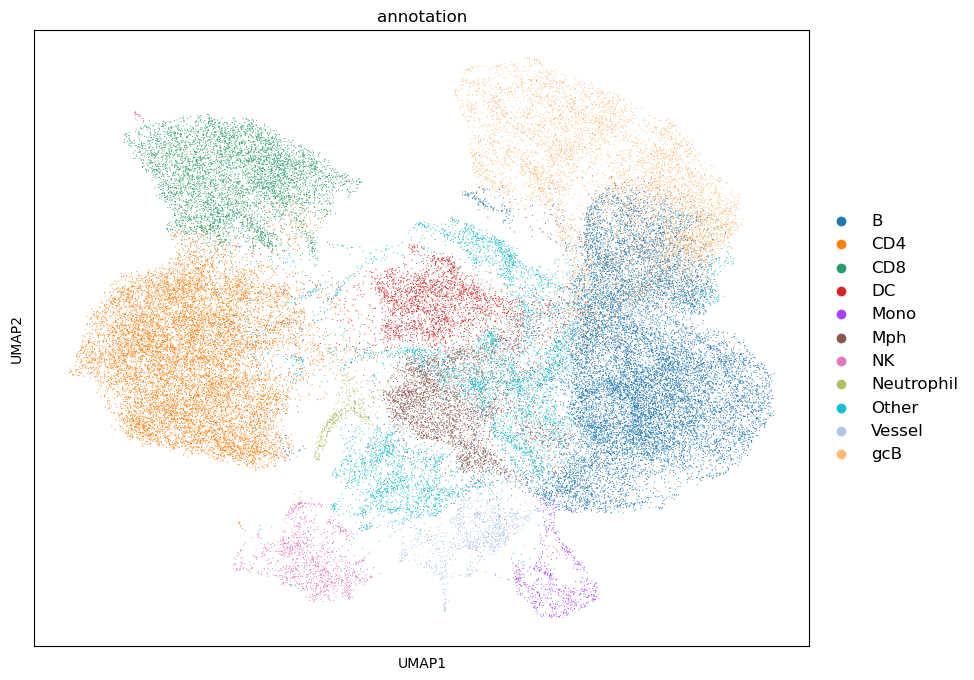

In [17]:
sc.pp.neighbors(gnn_adata, n_neighbors=10)
sc.tl.umap(gnn_adata)
plt.rcParams["figure.figsize"] = (10,8)
sc.pl.umap(gnn_adata, color='annotation', legend_fontsize=12, show=False)

## save out the result

In [15]:
save_folder = '../data/'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
np.save(os.path.join(save_folder, f"double_snap_combo_stable_0327.npy"), gnn_embedding)